In [768]:
import numpy as np 
import pandas as pd


In [769]:
df=pd.read_excel(r'D:\Project\Mlproject\Data\ai_dev_assignment_tickets_complex_1000.xls')

In [770]:
df.head()

,ticket_id,ticket_text,issue_type,urgency_level,product
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2
1,2,Can you tell me more about the UltraClean Vacu...,General Inquiry,NaN,UltraClean Vacuum
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam
4,5,Order #30903 for Vision LED TV is 13 days late...,Late Delivery,NaN,Vision LED TV


im thinking of adding  sentiment analysis  column as feature  for  bad  good netural   

length  of

In [771]:
df.drop("ticket_id",inplace=True,axis=1)

In [772]:
df['issue_type'].value_counts(dropna=False)


issue_type
Billing Problem       146
General Inquiry       146
Account Access        143
Installation Issue    142
Product Defect        121
Wrong Item            114
Late Delivery         112
NaN                    76
Name: count, dtype: int64

In [773]:
df['product'].value_counts(dropna=False)

product
RoboChef Blender     116
Vision LED TV        109
PhotoSnap Cam        103
FitRun Treadmill     102
PowerMax Battery     102
EcoBreeze AC         100
ProTab X1             99
SmartWatch V2         95
SoundWave 300         90
UltraClean Vacuum     84
Name: count, dtype: int64


o Handling missing data 

In [774]:
df.isnull().sum()

ticket_text      55
issue_type       76
urgency_level    52
product           0
dtype: int64

In [775]:
df[df['ticket_text'].isnull()].head()

,ticket_text,issue_type,urgency_level,product
9,NaN,Product Defect,High,PhotoSnap Cam
10,NaN,NaN,Medium,Vision LED TV
37,NaN,Billing Problem,High,PhotoSnap Cam
42,NaN,Billing Problem,Medium,ProTab X1
83,NaN,General Inquiry,Low,RoboChef Blender


In [776]:
# Drop rows where both ticket_text and issue_type are null
df = df.drop(df[df['ticket_text'].isnull() & df['issue_type'].isnull()].index)


In [777]:
df.isnull().sum()

ticket_text      53
issue_type       74
urgency_level    52
product           0
dtype: int64

#Imputing With Unknown

In [778]:
df['ticket_text'] = df['ticket_text'].fillna('Unknown')
# Flag missing issue_type
df["issue_type_missing"] = df["issue_type"].isna().astype(int)




In [779]:
df.isnull().sum()

ticket_text            0
issue_type            74
urgency_level         52
product                0
issue_type_missing     0
dtype: int64

In [780]:
df[df['issue_type'].isnull()]

,ticket_text,issue_type,urgency_level,product,issue_type_missing
8,Both my FitRun Treadmill and UltraClean Vacuum...,NaN,High,FitRun Treadmill,1
12,Vision LED TV is no response. It stopped worki...,NaN,NaN,Vision LED TV,1
25,Facing installation issue with RoboChef Blende...,NaN,Medium,RoboChef Blender,1
36,Can't log in to my account. Keeps showing bloc...,NaN,High,FitRun Treadmill,1
57,Can you tell me more about the warranty? Also...,NaN,High,Vision LED TV,1
...,...,...,...,...,...
941,Order #26699 for Vision LED TV is 6 days late....,NaN,Low,Vision LED TV,1
952,Not able to install my product.,NaN,Low,EcoBreeze AC,1
963,Can you tell me more about the warranty? Also...,NaN,Low,PhotoSnap Cam,1
972,ProTab X1 is charged. It stopped working after...,NaN,High,ProTab X1,1


Basic Preprocessing

Lower case
Tokenization
remove stopwords
Stemming / Lemmatizatio

In [781]:
df['ticket_text']=df['ticket_text'].apply(lambda x:x.lower())

Didnt did directly  as  i lost accuracy 

#StopWord Removal
o Tokenization, stopword removal, lemmatization 

In [782]:
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        # keep only alphabetic tokens, remove stopwords
        if token.is_alpha and not token.is_stop:
            tokens.append(token.lemma_)  # use lemma instead of raw token
    return " ".join(tokens)

sample ="The product was delivered late and I was charged twice"
print(preprocess_text(sample))

product deliver late charge twice


In [783]:
# Apply preprocessing to every row in ticket_text
df["clean_text"] = df["ticket_text"].apply(preprocess_text)


 Feature Engineering

In [784]:
df["token_length"] = df["ticket_text"].str.len()


In [785]:
import pandas as pd
from textblob import TextBlob


# Function to compute sentiment
def get_sentiment(text):
    if pd.isnull(text) or text.strip() == "":
        return 0.0, "neutral"
    
    blob = TextBlob(text)
    score = blob.sentiment.polarity  # -1 to +1
    
    # Map score to label
    if score < -0.2:
        label = "frustrated"
    elif score > 0.2:
        label = "happy"
    else:
        label = "neutral"
    
    return score, label

# Apply function to cleaned text column
df["sentiment_score"], df["sentiment_label"] = zip(*df["ticket_text"].map(get_sentiment))



In [786]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score



def bagging_decision_tree_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    bagging = BaggingClassifier(
    n_estimators=100,        # number of trees
    max_samples=0.8,         # fraction of samples per tree
    random_state=44)

    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    return bagging,y_test, y_pred

In [787]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

def test_func(X, y,max_iter):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    

    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    return model,y_test, y_pred

In [788]:

import seaborn as sns
import matplotlib.pyplot as plt
def cf_matrix(y_true, y_pred):
    labels = sorted(y_true.unique())
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels,
                yticklabels=labels)
    plt.title("Confusion Matrix -  (Issue Type)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [789]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

def issue_type_classifier(df, text_col="ticket_text", target_col="issue_type"):
    # TF-IDF features
    tfidf = TfidfVectorizer(max_features=200)

    labeled_mask = df["issue_type"].notna() & df["urgency_level"].notna()
    df_labeled = df[labeled_mask].copy() 
    X = tfidf.fit_transform(df_labeled[text_col])
    y = df_labeled[target_col]

    labeled_mask = df["issue_type"].notna() & df["urgency_level"].notna()
    df_labeled = df[labeled_mask].copy() 

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    issue_clf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees grow fully
    class_weight="balanced",# handle class imbalance
    random_state=42
)
    issue_clf.fit(X_train, y_train)

    # Predictions
    y_pred = issue_clf.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    return issue_clf, tfidf, y_test, y_pred


In [790]:
issue_clf,tfidf,y_test,y_pred=issue_type_classifier(df, text_col="ticket_text", target_col="issue_type")

Accuracy: 0.9772727272727273

Classification Report:
                     precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        27
   Billing Problem       1.00      0.93      0.96        28
   General Inquiry       1.00      0.93      0.96        28
Installation Issue       1.00      1.00      1.00        27
     Late Delivery       0.84      1.00      0.91        21
    Product Defect       1.00      1.00      1.00        23
        Wrong Item       1.00      1.00      1.00        22

          accuracy                           0.98       176
         macro avg       0.98      0.98      0.98       176
      weighted avg       0.98      0.98      0.98       176



Transform ticket_text into TF-IDF features

Missing value_Imputation of Issue Type

In [791]:

X_all = tfidf.transform(df["ticket_text"])

# Predict issue_type for all rows
issue_type_preds = issue_clf.predict(X_all)

# Impute only missing values in issue_type
df.loc[df["issue_type"].isna(), "issue_type"] = issue_type_preds[df["issue_type"].isna()]


In [792]:
df.columns

Index(['ticket_text', 'issue_type', 'urgency_level', 'product',
       'issue_type_missing', 'clean_text', 'token_length', 'sentiment_score',
       'sentiment_label'],
      dtype='object')

In [793]:
'''# Filter only failed predictions
df_failed = df_with_tfidf[df_with_tfidf["predicted_issue_type"] != df_with_tfidf["issue_type"]]

# Group by true vs predicted labels and count
misclass_summary = (
    df_failed.groupby(["issue_type", "predicted_issue_type"])
    .size()
    .reset_index(name="count")
)

print(misclass_summary)'''


'# Filter only failed predictions\ndf_failed = df_with_tfidf[df_with_tfidf["predicted_issue_type"] != df_with_tfidf["issue_type"]]\n\n# Group by true vs predicted labels and count\nmisclass_summary = (\n    df_failed.groupby(["issue_type", "predicted_issue_type"])\n    .size()\n    .reset_index(name="count")\n)\n\nprint(misclass_summary)'

In [794]:
df.columns

Index(['ticket_text', 'issue_type', 'urgency_level', 'product',
       'issue_type_missing', 'clean_text', 'token_length', 'sentiment_score',
       'sentiment_label'],
      dtype='object')

In [795]:
df.isnull().sum()    

ticket_text            0
issue_type             0
urgency_level         52
product                0
issue_type_missing     0
clean_text             0
token_length           0
sentiment_score        0
sentiment_label        0
dtype: int64

2. Urgency Level Classifier: Predict the urgency_level (multi-class classification)
Bag-of-Words for each category low, medium and High
NO_of_days
Order_number
No_of words
No_of_sentences (.,?)
One_hot_encode Product and Issue_type
appliance_product
Usage_keywords

In [ ]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer

def feature_engineering_urgency(dfx):



    dfx = dfx.fillna({
    "ticket_text": "",
    "issue_type": "Unknown",
    "product": "Unknown",
    "urgency_level": "Unknown"})

    # Drop rows without usable target
    dfx = dfx[dfx["urgency_level"] != "Unknown"].copy()
    

 
    def clean_text(text):
        return re.sub(r"[^a-zA-Z0-9\s]", "", str(text).lower())
    
    def extract_days(text):
        m = re.search(r"(\d+)\s*days", str(text).lower())
        return int(m.group(1)) if m else 0
    
    def extract_order(text):
        m = re.search(r"order\s*#?(\d+)", str(text).lower())
        return int(m.group(1)) if m else 0
    
    dfx["clean_text"] = dfx["ticket_text"].apply(clean_text)

    low_texts = dfx[dfx["urgency_level"] == "Low"]["clean_text"]
    med_texts = dfx[dfx["urgency_level"] == "Medium"]["clean_text"]
    high_texts = dfx[dfx["urgency_level"] == "High"]["clean_text"]

    vec_low = CountVectorizer()
    vec_med = CountVectorizer()
    vec_high = CountVectorizer()

    vec_low.fit(low_texts)
    vec_med.fit(med_texts)
    vec_high.fit(high_texts)

    vocab_low = set(vec_low.get_feature_names_out())
    vocab_med = set(vec_med.get_feature_names_out())
    vocab_high = set(vec_high.get_feature_names_out())

    unique_low = vocab_low - (vocab_med | vocab_high)
    unique_med = vocab_med - (vocab_low | vocab_high)
    unique_high = vocab_high - (vocab_low | vocab_med)

    def contains_unique(text, unique_words):
        tokens = set(text.split())
        return int(len(tokens & unique_words) > 0)

    dfx["bow_low"] = dfx["clean_text"].apply(lambda x: contains_unique(x, unique_low))
    dfx["bow_medium"] = dfx["clean_text"].apply(lambda x: contains_unique(x, unique_med))
    dfx["bow_high"] = dfx["clean_text"].apply(lambda x: contains_unique(x, unique_high))


    df1=dfx.copy()

    appliance_products = ["tv", "blender", "vacuum", "ac", "treadmill"]
    df1["appliance_related"] = df1["product"].str.lower().apply(
    lambda x: int(any(appliance in x for appliance in appliance_products)))

    usage_keywords = ["access", "install", "installation", "setup", "login",'underbilled']
    df1["usage_related"] = df1["ticket_text"].str.lower().apply(
    lambda x: int(any(word in x for word in usage_keywords)))


    
    special_chars = ['.', '!',  '?']
    df1["number_of_sentence"] = df1["ticket_text"].apply(
    lambda x: sum(x.count(ch) for ch in special_chars))

    #structured features
    dfx["word_length"] = dfx["ticket_text"].apply(lambda x: len(str(x).split()))
    dfx["no_of_days"] = dfx["ticket_text"].apply(extract_days)
    dfx["order_number"] = dfx["ticket_text"].apply(extract_order)


    #one-hot encoding
    df_encoded = pd.get_dummies(dfx, columns=["product", "issue_type"], drop_first=True)




    drop_cols = ["ticket_id", "ticket_text", "clean_text", "urgency_level",'sentiment_label','issue_type_pred' ]
    X = df_encoded.drop(columns=[c for c in drop_cols if c in df_encoded.columns])
    # explicitly add engineered features back 
    X = pd.concat([X, df1[["appliance_related", "usage_related", "number_of_sentence"]]], axis=1)
    y = df_encoded["urgency_level"]
    df_final=pd.concat([X, y], axis=1)
  


    return X, y,df_final



In [797]:

df.dropna(subset=["urgency_level"],inplace=True)
df.drop(columns=["sentiment_label"],inplace=True)



Model Selection

In [798]:
X, y ,df_final= feature_engineering_urgency(df)

model,y_test, y_pred = test_func(X, y,max_iter=100)
#cf_matrix(y_test, y_pred) 


Accuracy: 0.5368421052631579

Classification Report:
               precision    recall  f1-score   support

        High       0.70      0.42      0.53        66
         Low       0.43      0.87      0.57        60
      Medium       0.79      0.34      0.48        64

    accuracy                           0.54       190
   macro avg       0.64      0.54      0.53       190
weighted avg       0.64      0.54      0.53       190



In [815]:
X, y,df_final = feature_engineering_urgency(df)
bagging,y_test, y_pred = bagging_decision_tree_classifier(X, y)
#cf_matrix(y_test, y_pred)   

Accuracy: 0.5684210526315789

Classification Report:
               precision    recall  f1-score   support

        High       0.58      0.59      0.58        70
         Low       0.60      0.52      0.56        65
      Medium       0.53      0.60      0.56        55

    accuracy                           0.57       190
   macro avg       0.57      0.57      0.57       190
weighted avg       0.57      0.57      0.57       190



In [816]:
df_recall=pd.read_excel(r'D:\Project\Mlproject\Data\ai_dev_assignment_tickets_complex_1000.xls')

X, y ,df_final= feature_engineering_urgency(df_recall)

model3,y_test, y_pred = test_func(X, y,max_iter=156)
#cf_matrix(y_test, y_pred) 


Accuracy: 0.5526315789473685

Classification Report:
               precision    recall  f1-score   support

        High       0.84      0.41      0.55        66
         Low       0.67      0.37      0.47        60
      Medium       0.45      0.88      0.59        64

    accuracy                           0.55       190
   macro avg       0.65      0.55      0.54       190
weighted avg       0.65      0.55      0.54       190



In [801]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

Accuracy: 0.631578947368421

Classification Report:
               precision    recall  f1-score   support

        High       0.67      0.61      0.63        66
         Low       0.63      0.60      0.62        60
      Medium       0.60      0.69      0.64        64

    accuracy                           0.63       190
   macro avg       0.63      0.63      0.63       190
weighted avg       0.63      0.63      0.63       190



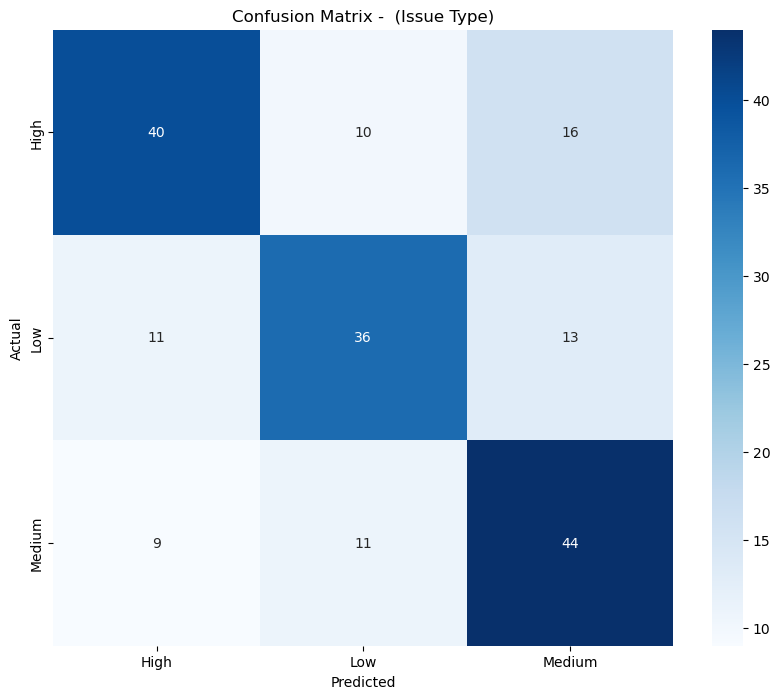

In [812]:
from sklearn.ensemble import VotingClassifier

# Assume model1 and model2 are already trained
ensemble = VotingClassifier(
    estimators=[("model1", model), ("model2",bagging),("model3",model3)],
    voting="soft" ,  # use probabilities
    weights=[2,2,1.5]
)



ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cf_matrix(y_test, y_pred)



o Complaint keywords (e.g., “broken”, “late”, “error”) 

In [804]:
import spacy, re
nlp = spacy.load("en_core_web_sm")

# Example product list and complaint keywords
product_list =df['product'].unique()
complaint_keywords = [
    "broken",
    "late",
    "error",
    "faulty",
    "damaged",
    "missing",
    "wrong",
    "delay",
    "lost",
    "no response"
    "charged"
]


KeyboardInterrupt: 

Using traditional NLP, extract key entities from ticket_text: 
o Product names (from a provided product list or using regex/rule-based 
methods) 
o Dates mentioned in the text 

In [ ]:
def extract_entities(text):
    text_lower = text.lower()
    doc = nlp(text)
    entities = {"products": [], "dates": [], "order_number": [], "complaints": []}
    
    # Products
    for product in product_list:
        if product.lower() in text_lower:
            entities["products"].append(product)
    
    # Dates
    for ent in doc.ents:
        if ent.label_ == "DATE":
            entities["dates"].append(ent.text)
    regex_dates = re.findall(r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b", text)
    entities["dates"].extend(regex_dates)
    
    # Order numbers
    order_ids = re.findall(r"(?:order\s*#?\s*\d+|#\d+)", text_lower)
    entities["order_number"].extend(order_ids)
    
    # Complaint keywords
    for token in doc:
        if token.lemma_.lower() in complaint_keywords:
            entities["complaints"].append(token.lemma_.lower())
    if "no response" in text_lower:
        entities["complaints"].append("no response")
    
    # Deduplicate
    entities = {k: list(set(v)) for k,v in entities.items()}
    
    return {"entities": entities}


In [ ]:
sample=df['ticket_text'][66]
print(extract_entities(sample))
print(sample)

{'entities': {'products': ['SmartWatch V2'], 'dates': ['16 march', '14 days'], 'order_number': ['order #96823'], 'complaints': ['late']}}
order #96823 for smartwatch v2 is 14 days late. ordered on 16 march.


o Extracted entities (as a JSON/dictionary) 

In [ ]:
df["extracted_entities"] = df["ticket_text"].apply(extract_entities)


In [ ]:
import pickle

def save_pipeline(urgency_model, issue_type_model, tfidf_vectorizer, filename="ticket_classifier.pkl"):
    bundle = {

        # Issue type classification
        "tfidf_vectorizer": tfidf_vectorizer,
        "issue_type_model": issue_clf,
        


        
        # Urgency classification
        
        "feature_engineering": feature_engineering_urgency,
        "urgency_model": urgency_model,
        "extract_entities": extract_entities,

        
    }
    with open(filename, "wb") as f:
        pickle.dump(bundle, f)
    print(f"Pipeline saved to {filename}")
